# Crypt fusion as a homeostatic mechanism in the human colon

This Jupyter Notebook is an accompaniment to the paper 'Crypt fusion as a homeostatic mechanism in the human colon'. In this paper, we present the first evidence of crypt fusion - a process in which two neighbouring crypts spontaneously join to form a single daughter crypt - in the human colon. 

As described in the manuscript, somatically acquired CCO deficiency was utilised as a lineage tracing marker to assess the clonality of bifurcating neighbouring crypts. For 13 patients, serial sections of tissue were availible and were used to score crypt bifurcation frequencies. Of the 59,721 crypts observed, 309 were found to be bifurcating. For 21 of these bifurcating crypts, all the CCO deficient cells were segregated to a single arm of the bifurcation. This is suggestive that the crypts were undergoing crypt fusion. To test this hypothesis, we attempted to estimate the probability that we would see this many (or more) segregated crypts wholly under crypt fission. For a detailed description of the approach taken, please consult the supplementary information of the manuscript. 

Next, we sought to examine the effect that crypt fusion will have on the estimates of the crypt fission rate inferred from the patch size distribution. The modified patch size distribution including the possibility of crypt fusion is derived in the manuscript. We minimize the log-likelihood of the patch size distribution to provide a MLE estimate of the fission rate. 

Finally, we explore spatial correlations in the positions of the bifurcations. We utilize Ripley's L function as a measure of spatial heterogeneity and compare this for each patient image to the distribution of $999$ randomly generated simulations. We find evidence of clustering in patient samples 4, 6, 7A, 7B, 8 and 10.


# Data Sources

- data/PatchSizeData.csv

This csv file contains the the patch size data from the 22 patients included in the paper, along with the age and diagnosis of each patient and the total number of crypts analysed. It also includes the number and type of bifurcations for the 13 patients for whom serial sections were readily availible.

- data/images

This folder contains images of a section of colon stained for CCO activity, with coloured circles superimposed on top of the image on top of the bifurcations for the 10 patients (1-10) for whom serial sections exist and which contain more than 2000 crypts. The colour of the circles indicates the type of the bifurcation: <br>
Green - Type 1 <br>
Purple - Type 2 <br>
Red - Type 3 <br>

- data/Ripley

This folder contains a separate folder for patients 1-10, each of which contains the coordinates of the bifurcations, the coordinates of the 999 simulated points, the calculated Ripley's K and L functions for the real positions of the bifurcations, the calculated Ripley's K and L functions for each simulation and a mask of the sample foreground.


# Analysis

In [1]:
# Import relevant python modules

import os
import numpy as np
import pandas as pd
from scipy import optimize, spatial, misc
import numdifftools as ndt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, special
from decimal import *
import cv2
import random
from skimage import measure, filters, color, morphology
from skimage.draw import circle_perimeter

In [2]:
# Define functions

def patch_size_distribution(b, d, t, m):
    x = simplifying_function(b, d, t)
    K_m = x ** m / ( m * np.log(1 / (1 - x) ) )
    return K_m

def simplifying_function(b, d, t):
    x = (1 - np.exp(-(b-d)*t))/(1-d/b * np.exp(-(b-d)*t))
    return x

def neglike(b, t, patches, ratio = 0.5):
    d = b * ratio

    if abs(b - d) > 1e-3:
        x = simplifying_function(b, d, t)

    else:
        x = b*t/(1+b*t)

    LL = -1 *np.sum(
    patches * np.log(x) 
    - np.log(patches * np.log(1 / (1-x)))
    )

    return LL

def function_to_min(t, patches, ratio):
    # A wrapper function that is a function of a single parameter for 
    # use with minimize
    return lambda b: neglike(b, t, patches, ratio)

def correction(data):
    # A correction to the patch size data to account for the possibility of
    # neighbouring crypts becoming spontaneously labelled
    
    data = data.copy()
    
    total = data.TotalCrypts
    number_of_neighbours = 4
    number_of_patches = np.sum(data.loc[:, '1':'15'], axis = 1)

    # Correct the data for spontaneous mutation of adjacent patches
    mutation_rate = number_of_patches/total
    data['1'] = data['1'] + 2*np.round((mutation_rate)**2 * (1-mutation_rate)**(2*number_of_neighbours-2) * (number_of_neighbours / 2) * total)
    data['2'] = data['2'] - np.round((mutation_rate)**2 * (1-mutation_rate)**(2*number_of_neighbours-2) * (number_of_neighbours / 2) * total)
    data.loc[data['2'] < 0, '2'] = 0

    return data
        
flatten = lambda l: [item for sublist in l for item in sublist]


In [3]:
# Load bifurcation and patch size data from a csv file 
DataPath = 'data/PatchSizeData.csv'
Data = pd.read_csv(DataPath)

pd.options.display.max_columns = None

Data

PatientNumber Disease  Ages  TotalCrypts  Total brown  Total blue  \
0              1  Normal    79         4919       4086.0       497.0   
1              2  Normal    60         3547       3424.0        70.0   
2              3  Normal    64         6958       6798.0       101.0   
3              4     FAP    67         6417       5910.0       287.0   
4              5     FAP    59         4095       3713.0       193.0   
5              6     FAP    39         3085       3018.0        43.0   
6             7A    AFAP    64         5448       5213.0       148.0   
7             7B    AFAP    64         5065       4463.0       291.0   
8              8    AFAP    65        11755      11351.0       213.0   
9              9    AFAP    61         4174       3641.0       282.0   
10            10    AFAP    60         2038       1962.0        52.0   
11           11A     IBD    66          272        256.0        15.0   
12           11B     IBD    66          402        378.0        21.0   
13            12     IBD    72          301        238.0        58.0   
14            13     IBD    65         1245       1057.0       102.0   
15            14  Normal    42         2702          NaN         NaN   
16            15  Normal    50         2878          NaN         NaN   
17            16  Normal    50         2883          NaN         NaN   
18            17  Normal    62        12030          NaN         NaN   
19            18  Normal    65        29839          NaN         NaN   
20            19  Normal    72         4101          NaN         NaN   
21            20  Normal    74         8792          NaN         NaN   
22            21  Normal    74        22045          NaN         NaN   
23            22  Normal    80         6249          NaN         NaN   
24            23  Normal    82        10341          NaN         NaN   
25            24  Normal    84        11821          NaN         NaN   

    Total partial  Total bifurcations  Type 1  Type 2  Type 3      1      2  \
0           336.0                 7.0     5.0     2.0     0.0  228.0   71.0   
1            53.0                 3.0     3.0     0.0     0.0   54.0    1.0   
2            59.0                 5.0     5.0     0.0     0.0   86.0    6.0   
3           220.0                44.0    41.0     1.0     2.0  106.0   49.0   
4           189.0                23.0    20.0     3.0     0.0   40.0   15.0   
5            24.0                48.0    48.0     0.0     0.0   29.0    4.0   
6            87.0                54.0    50.0     3.0     1.0   67.0   26.0   
7           311.0                25.0    20.0     3.0     2.0  128.0   39.0   
8           191.0                25.0    18.0     0.0     7.0   86.0   39.0   
9           251.0                27.0    20.0     2.0     5.0   65.0   37.0   
10           24.0                16.0    14.0     1.0     1.0   24.0   11.0   
11            1.0                 3.0     3.0     0.0     0.0    NaN    NaN   
12            3.0                 1.0     1.0     0.0     0.0    NaN    NaN   
13            5.0                 3.0     1.0     0.0     2.0    NaN    NaN   
14           86.0                25.0    22.0     2.0     1.0    NaN    NaN   
15            NaN                 NaN     NaN     NaN     NaN   20.0    6.0   
16            NaN                 NaN     NaN     NaN     NaN   20.0    6.0   
17            NaN                 NaN     NaN     NaN     NaN   29.0    6.0   
18            NaN                 NaN     NaN     NaN     NaN   90.0    6.0   
19            NaN                 NaN     NaN     NaN     NaN  158.0   12.0   
20            NaN                 NaN     NaN     NaN     NaN   52.0   11.0   
21            NaN                 NaN     NaN     NaN     NaN  164.0   65.0   
22            NaN                 NaN     NaN     NaN     NaN  232.0   34.0   
23            NaN                 NaN     NaN     NaN     NaN   97.0   20.0   
24            NaN                 NaN     NaN     NaN     NaN  210.0  121.0   
25  

In [4]:
I = pd.notna(Data['Type 1'])

BiData = Data.loc[I, 'PatientNumber':'Type 3']

BiData

PatientNumber Disease  Ages  TotalCrypts  Total brown  Total blue  \
0              1  Normal    79         4919       4086.0       497.0   
1              2  Normal    60         3547       3424.0        70.0   
2              3  Normal    64         6958       6798.0       101.0   
3              4     FAP    67         6417       5910.0       287.0   
4              5     FAP    59         4095       3713.0       193.0   
5              6     FAP    39         3085       3018.0        43.0   
6             7A    AFAP    64         5448       5213.0       148.0   
7             7B    AFAP    64         5065       4463.0       291.0   
8              8    AFAP    65        11755      11351.0       213.0   
9              9    AFAP    61         4174       3641.0       282.0   
10            10    AFAP    60         2038       1962.0        52.0   
11           11A     IBD    66          272        256.0        15.0   
12           11B     IBD    66          402        378.0        21.0   
13            12     IBD    72          301        238.0        58.0   
14            13     IBD    65         1245       1057.0       102.0   

    Total partial  Total bifurcations  Type 1  Type 2  Type 3  
0           336.0                 7.0     5.0     2.0     0.0  
1            53.0                 3.0     3.0     0.0     0.0  
2            59.0                 5.0     5.0     0.0     0.0  
3           220.0                44.0    41.0     1.0     2.0  
4           189.0                23.0    20.0     3.0     0.0  
5            24.0                48.0    48.0     0.0     0.0  
6            87.0                54.0    50.0     3.0     1.0  
7           311.0                25.0    20.0     3.0     2.0  
8           191.0                25.0    18.0     0.0     7.0  
9           251.0                27.0    20.0     2.0     5.0  
10           24.0                16.0    14.0     1.0     1.0  
11            1.0                 3.0     3.0     0.0     0.0  
12            3.0                 1.0     1.0     0.0     0.0  
13            5.0                 3.0     1.0     0.0     2.0  
14           86.0                25.0    22.0     2.0     1.0

In [5]:
getcontext().prec = 40

Npartial = Decimal(int(np.sum(BiData['Total partial'])))
Ntotal = Decimal(int(np.sum(BiData['TotalCrypts'])))
Nbifurcate = int(np.sum(BiData['Total bifurcations']))
Nseg = int(np.sum(BiData['Type 3']))

print('Number of stem cells per crypt : probability of observing {} or more segregated crypts'.format(Nseg))

for S in range(5, 11):

    S = Decimal(S)                # Number of stem cells per crypt

    p = 2 / (S * (S-1)) * Npartial / Ntotal

    k = np.arange(0, Nseg)

    prob = list()
    for k in range(0, Nseg):
        nchoosek = Decimal(special.comb(Nbifurcate, k, exact=True))
        Pk = nchoosek * (p ** k) * ((1 - p) ** (Nbifurcate - k))
        prob.append(Pk)

    Prob_seg = Decimal(1) - sum(prob) 
    
    print('{} : {:.2e}'.format(S,Prob_seg))

Number of stem cells per crypt : probability of observing 21 or more segregated crypts
5 : 1.49e-21
6 : 3.96e-25
7 : 3.98e-28
8 : 1.05e-30
9 : 5.71e-33
10 : 5.52e-35


In [6]:
row = pd.notna(Data['1'])
col = pd.notna(Data.iloc[-1])
PatchData = Data.loc[row, col].reset_index(drop = True)

PatchData

PatientNumber Disease  Ages  TotalCrypts      1      2     3     4    5  \
0              1  Normal    79         4919  228.0   71.0  23.0   6.0  3.0   
1              2  Normal    60         3547   54.0    1.0   2.0   2.0  0.0   
2              3  Normal    64         6958   86.0    6.0   1.0   0.0  0.0   
3              4     FAP    67         6417  106.0   49.0  17.0   4.0  7.0   
4              5     FAP    59         4095   40.0   15.0  13.0   8.0  8.0   
5              6     FAP    39         3085   29.0    4.0   2.0   0.0  0.0   
6             7A    AFAP    64         5448   67.0   26.0   8.0   0.0  1.0   
7             7B    AFAP    64         5065  128.0   39.0  11.0   8.0  0.0   
8              8    AFAP    65        11755   86.0   39.0  11.0   4.0  0.0   
9              9    AFAP    61         4174   65.0   37.0  20.0  10.0  1.0   
10            10    AFAP    60         2038   24.0   11.0   2.0   0.0  0.0   
11            14  Normal    42         2702   20.0    6.0   0.0   1.0  0.0   
12            15  Normal    50         2878   20.0    6.0   0.0   0.0  0.0   
13            16  Normal    50         2883   29.0    6.0   2.0   1.0  1.0   
14            17  Normal    62        12030   90.0    6.0   2.0   1.0  0.0   
15            18  Normal    65        29839  158.0   12.0   1.0   1.0  0.0   
16            19  Normal    72         4101   52.0   11.0   0.0   1.0  0.0   
17            20  Normal    74         8792  164.0   65.0  20.0   9.0  5.0   
18            21  Normal    74        22045  232.0   34.0  45.0   5.0  2.0   
19            22  Normal    80         6249   97.0   20.0  15.0   4.0  5.0   
20            23  Normal    82        10341  210.0  121.0  31.0  23.0  9.0   
21            24  Normal    84        11821   89.0   51.0  40.0  16.0  8.0   

      6    7    8    9   10   11   12   13   14   15  
0   2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4   2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9   0.0  2.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
11  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
18  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
19  1.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
20  2.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  
21  1.0  3.0  2.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0

In [7]:
PatchData = correction(PatchData)
PatchData

PatientNumber Disease  Ages  TotalCrypts      1     2     3     4    5  \
0              1  Normal    79         4919  288.0  41.0  23.0   6.0  3.0   
1              2  Normal    60         3547   58.0   0.0   2.0   2.0  0.0   
2              3  Normal    64         6958   90.0   4.0   1.0   0.0  0.0   
3              4     FAP    67         6417  124.0  40.0  17.0   4.0  7.0   
4              5     FAP    59         4095   46.0  12.0  13.0   8.0  8.0   
5              6     FAP    39         3085   31.0   3.0   2.0   0.0  0.0   
6             7A    AFAP    64         5448   73.0  23.0   8.0   0.0  1.0   
7             7B    AFAP    64         5065  150.0  28.0  11.0   8.0  0.0   
8              8    AFAP    65        11755   92.0  36.0  11.0   4.0  0.0   
9              9    AFAP    61         4174   79.0  30.0  20.0  10.0  1.0   
10            10    AFAP    60         2038   26.0  10.0   2.0   0.0  0.0   
11            14  Normal    42         2702   22.0   5.0   0.0   1.0  0.0   
12            15  Normal    50         2878   20.0   6.0   0.0   0.0  0.0   
13            16  Normal    50         2883   31.0   5.0   2.0   1.0  1.0   
14            17  Normal    62        12030   94.0   4.0   2.0   1.0  0.0   
15            18  Normal    65        29839  162.0  10.0   1.0   1.0  0.0   
16            19  Normal    72         4101   56.0   9.0   0.0   1.0  0.0   
17            20  Normal    74         8792  190.0  52.0  20.0   9.0  5.0   
18            21  Normal    74        22045  248.0  26.0  45.0   5.0  2.0   
19            22  Normal    80         6249  109.0  14.0  15.0   4.0  5.0   
20            23  Normal    82        10341  258.0  97.0  31.0  23.0  9.0   
21            24  Normal    84        11821  103.0  44.0  40.0  16.0  8.0   

      6    7    8    9   10   11   12   13   14   15  
0   2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4   2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9   0.0  2.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
11  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
18  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
19  1.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
20  2.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  
21  1.0  3.0  2.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0

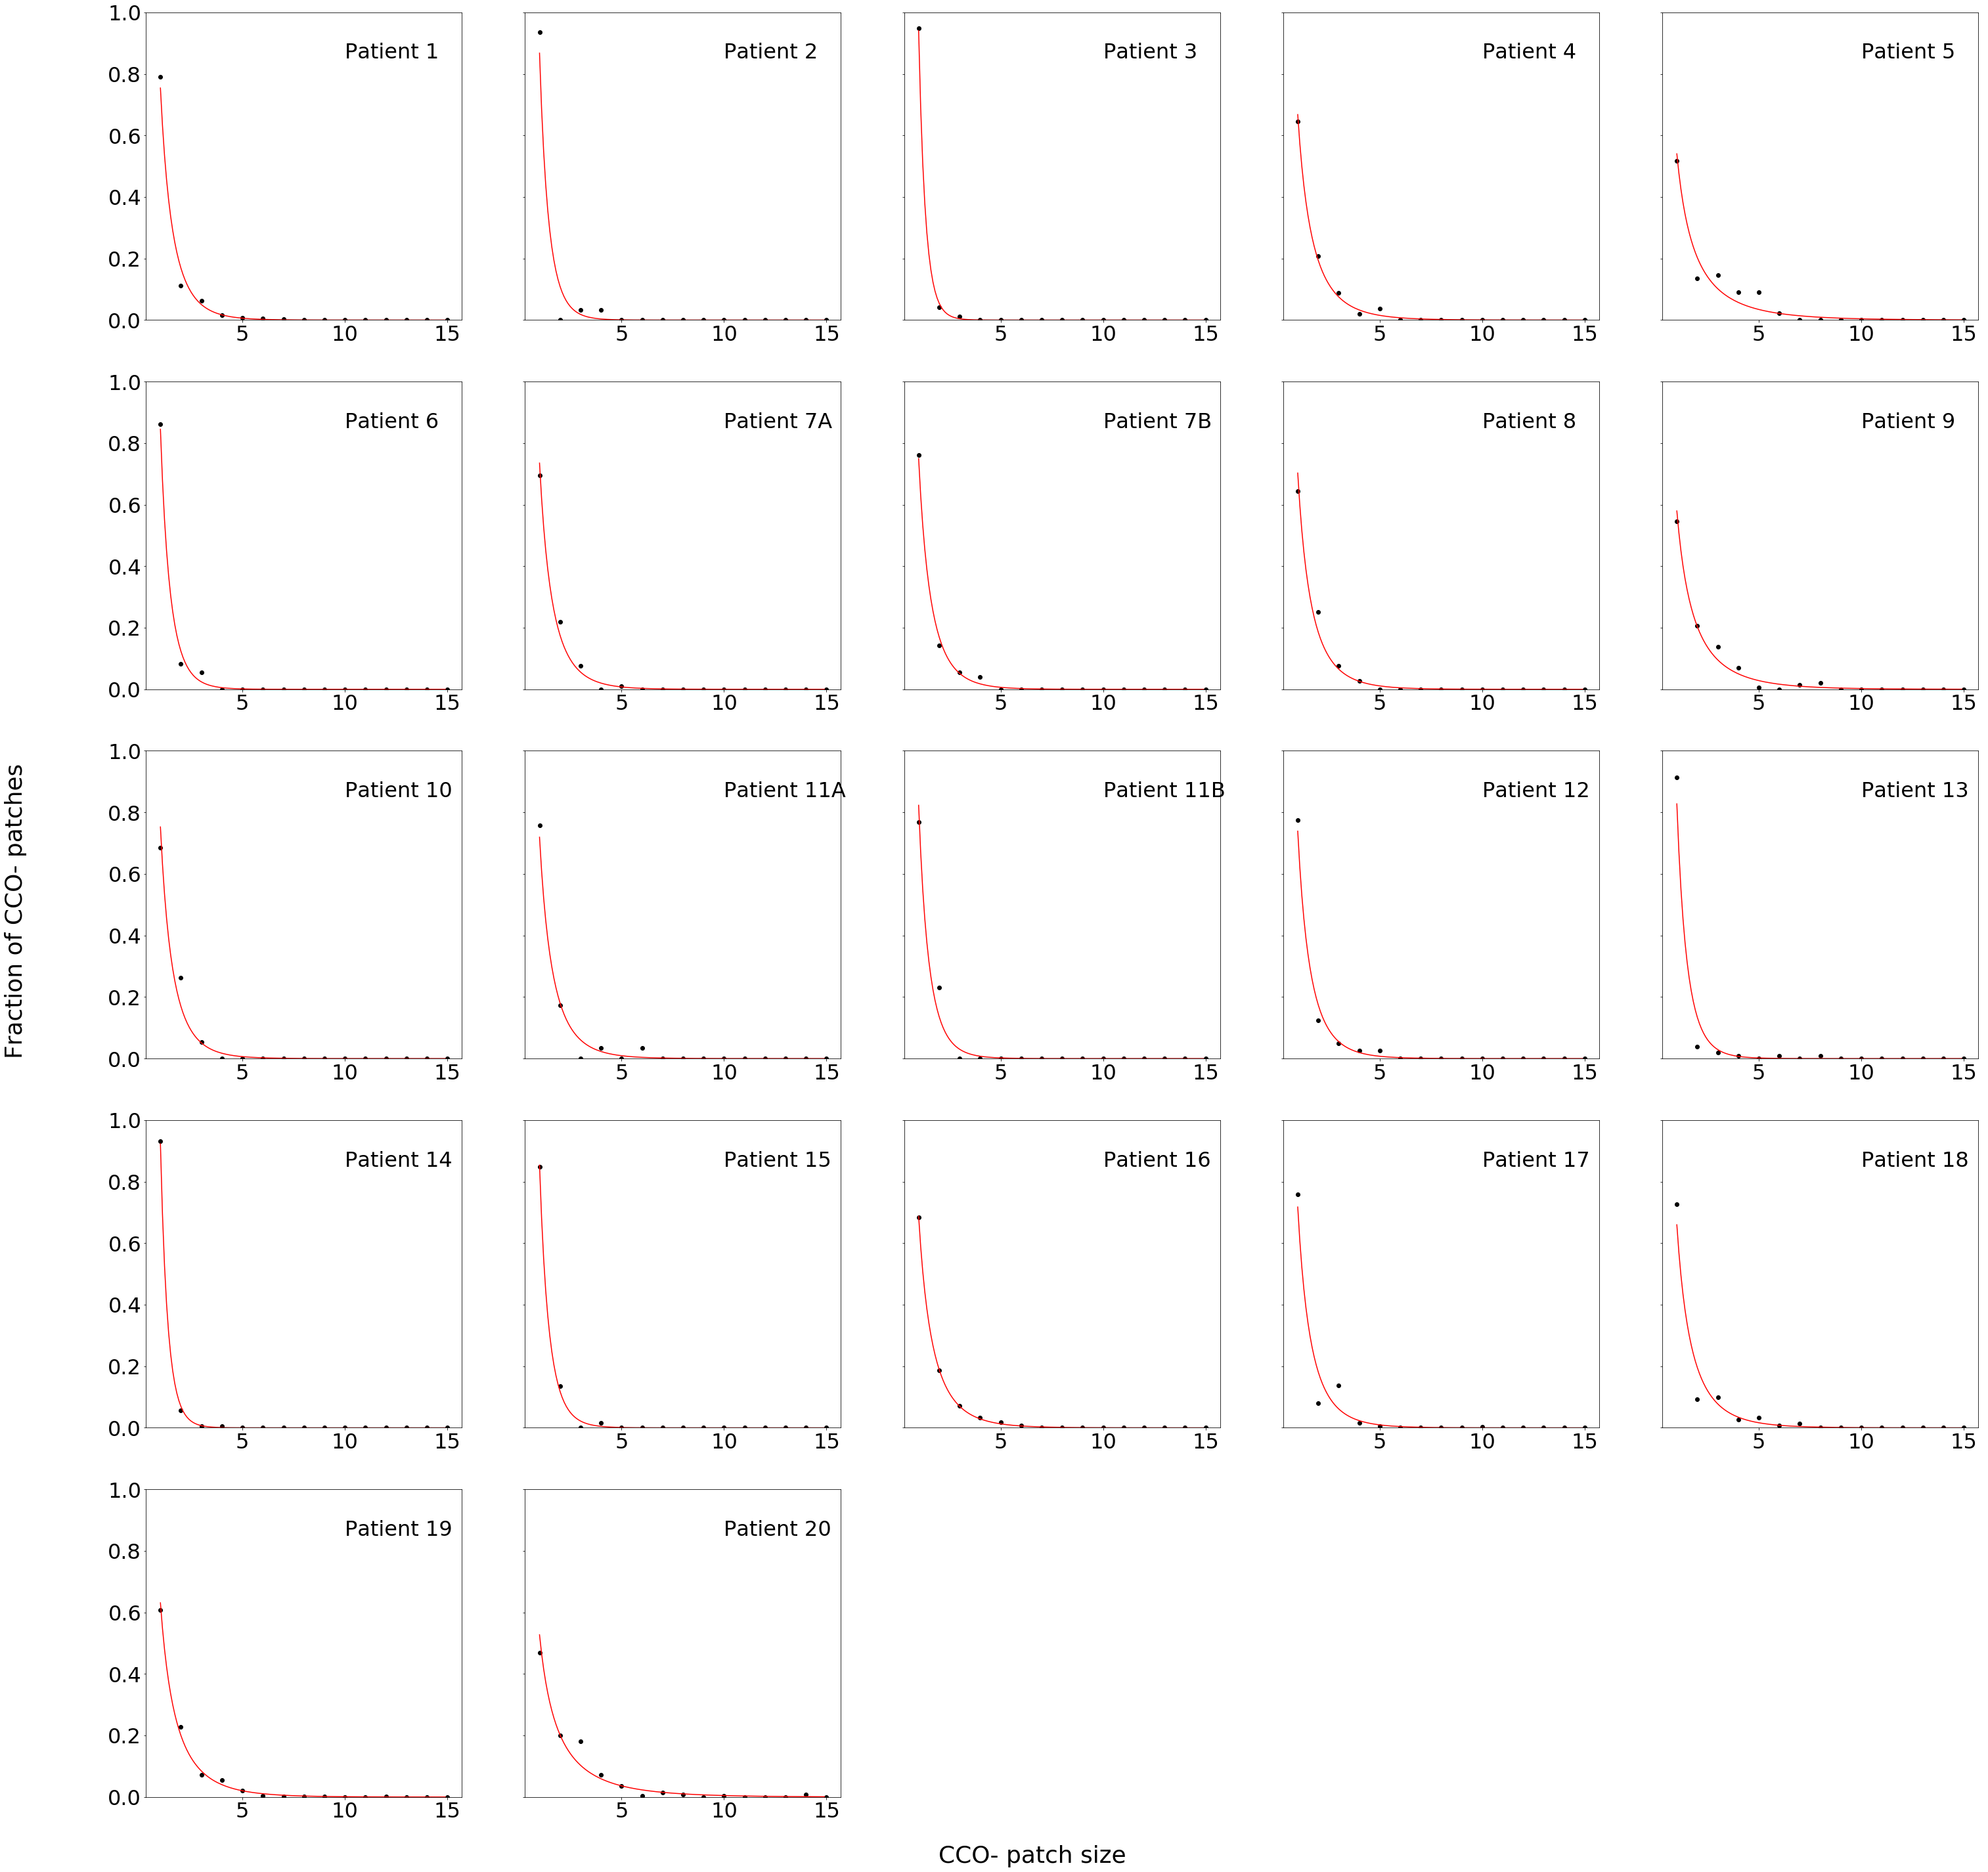

In [8]:
# Calculate the fission rate when we include fusion and plot the individual fits
ratio = 0.543

patch_data = PatchData.loc[:, '1':'15']
age = PatchData.Ages
patch = patch_data.columns.values.astype(int)

b_rate = list()
b_rate_fission = list()
b_rate_fission_error = list()
b_rate_error = list()

fig, axes = plt.subplots(5, 5, sharex='none', sharey='row', figsize=(50,50))
axes = axes.ravel()

mean_patch = list()
for index, t in enumerate(age):
    patch_dist = patch_data.loc[index, :]

    # convert the patch size distribution into a list of patch sizes
    patches = list()
    for i in range(len(patch_dist)):
        patches.append(int(patch_dist[i]) * [i+1])
    patches = np.array(flatten(patches))

    mean_patch_size = np.mean(patches)

        # estimate a reasonable guess at the fission rate 
    b_initial = 2 / t * (np.mean(patches) - 1)

    f_fusion = function_to_min(t, patches, ratio)
    f_fission = function_to_min(t, patches, 0)

    res = optimize.minimize(f_fusion, b_initial, method = 'Nelder-Mead', 
                    options={'disp': False})
    res_fission = optimize.minimize(f_fission, b_initial, method = 'Nelder-Mead', 
                    options={'disp': False})

    fusion_rate = res['x'][0]
    fission_rate = res_fission['x'][0]

    Hfun = ndt.Hessian(f_fusion, full_output=False, step=1e-4)
    hessian_ndt = Hfun(fusion_rate)
    se_fusion = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))[0]

    Hfun_fission = ndt.Hessian(f_fission, full_output=False, step=1e-4)
    hessian_ndt_fission = Hfun(fission_rate)
    se_fission = np.sqrt(np.diag(np.linalg.inv(hessian_ndt_fission)))[0]
    
    b_rate.append(fusion_rate)
    b_rate_error.append(se_fusion)
    b_rate_fission.append(fission_rate)
    b_rate_fission_error.append(se_fission)
    mean_patch.append(mean_patch_size)

    m = np.arange(1, 15, 0.1)
    estimated_patch = patch_size_distribution(fusion_rate, 
                fusion_rate * ratio, t, m)

    ax = axes[index]
    ax.scatter(patch, patch_dist/np.sum(patch_dist), c='k')
    ax.plot(m, estimated_patch, c='r')   
    ax.set_ylim([0, 1])
    ax.tick_params(axis='both', labelsize=32)
    ax.text(10, 0.85, 'Patient {}'.format(Data.loc[index, 'PatientNumber']), fontsize = 32)

for j in range(index+1, len(axes)):
    axes[j].axis('off')
fig.text(0.5, 0.1, "CCO- patch size", ha="center", va="center", fontsize=36)
fig.text(0.07, 0.5, "Fraction of CCO- patches", ha="center", va="center", rotation=90, fontsize=36)



PatchData['fission_fusion_rate'] = b_rate
PatchData['fission_fusion_rate_error'] = b_rate_error
PatchData['mean_patch_size'] = mean_patch

PatchData['fission_rate'] = b_rate_fission
PatchData['fission_rate_error'] = b_rate_fission_error



# ProcessedData

In [9]:
# Print the mean fission rate for each disease type when we include the possibility of fusion
print('When including fusion:\n')

disease = PatchData['Disease'].unique()

for d in disease:
    average = np.mean(PatchData.loc[PatchData['Disease'] == d, 'fission_fusion_rate'])
    sd = np.std(PatchData.loc[PatchData['Disease'] == d, 'fission_fusion_rate_error'], ddof=1)
    print('The mean fission rate for {} is {:.2} ± {:.1}'.format(d, average, sd))

When including fusion:

The mean fission rate for Normal is 0.011 ± 0.002
The mean fission rate for FAP is 0.019 ± 0.001
The mean fission rate for AFAP is 0.015 ± 0.0009


In [10]:
# Print the mean fission rate for each disease type when we include the possibility of fusion
print('When only considering fission:\n')

disease = PatchData['Disease'].unique()

for d in disease:
    average = np.mean(PatchData.loc[PatchData['Disease'] == d, 'fission_rate'])
    sd = np.std(PatchData.loc[PatchData['Disease'] == d, 'fission_rate_error'], ddof=1)
    print('The mean fission rate for {} is {:.2} ± {:.1}'.format(d, average, sd))

When only considering fission:

The mean fission rate for Normal is 0.009 ± 0.001
The mean fission rate for FAP is 0.015 ± 0.001
The mean fission rate for AFAP is 0.012 ± 0.0007


So including the possibility of fusion increases the mean estimated fission rate by ~20%

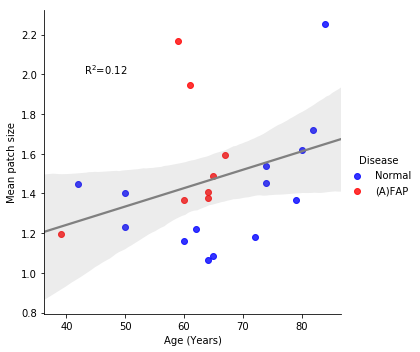

In [11]:
patch = np.arange(1, 16)

PatchData['marker'] = ['Normal' if x == 'Normal' else '(A)FAP' for x in PatchData['Disease']]

slope, intercept, r_value, p_value, std_err = stats.linregress(PatchData['Ages'], PatchData['mean_patch_size'])

g = sns.lmplot(x="Ages", y='mean_patch_size',  hue="marker", data=PatchData, fit_reg = False, palette={'Normal':'blue', '(A)FAP':'red'})
g._legend.set_title('Disease')
sns.regplot(x="Ages", y='mean_patch_size', data=PatchData, scatter = False, color='grey')
# plt.plot(t, estimated_mean_patch)
plt.xlabel("Age (Years)")
plt.ylabel("Mean patch size")
plt.text(43, 2.0, r'R$^2$={}'.format(round(r_value ** 2, 2)))
plt.show()

Text(0, 0.5, 'Estimated crypt fission/fusion rate (divisions/crypt/year)')

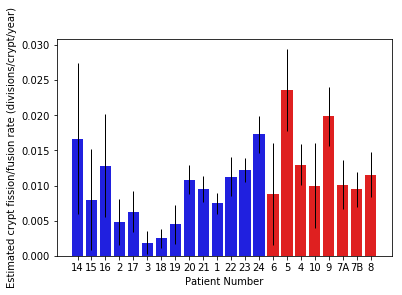

In [12]:
# Plot a bar chart of each patients calculated fission rate, sorted by age and coloured according to disease type

SortedData = PatchData.sort_values(['Disease', 'Ages'], ascending=[False, True])
clrs = ['blue' if (x == 'Normal') else 'red' for x in SortedData['Disease'] ]

fig = plt.figure()
sns.barplot('PatientNumber', 'fission_rate', data=SortedData, palette = clrs)
plt.errorbar(np.arange(np.shape(SortedData)[0]), SortedData.fission_rate, 
             yerr=SortedData.fission_rate_error * 1.96,
             linewidth=0, elinewidth=1, color='k', capthick=1)
plt.xlabel("Patient Number")
plt.ylabel("Estimated crypt fission/fusion rate (divisions/crypt/year)")

For the patients for whom we had both serial sections, allowing us to accurately classify bifurcations, and patch size data we can estimate the duration of crypt fission. 

In [13]:
# Find data for which we have both the number of bifurcations and the estimate of the fission rate

ind = pd.notna(Data['Total bifurcations']) & pd.notna(Data['1'])

DurationData = Data.loc[ind, ('PatientNumber', 'Disease', 'Ages', 'TotalCrypts', 'Total bifurcations')]
idx = PatchData.index.intersection(DurationData.index)
DurationData['fission_fusion_rate'] = PatchData.loc[idx, 'fission_fusion_rate']

In [14]:
# Estimate the duration of crypt fission (in weeks), assuming half of the bifurcations are due to fission

DurationData['Duration'] = DurationData['Total bifurcations'] / (2 * DurationData['fission_fusion_rate'] * DurationData['TotalCrypts']) * 52
DurationData

PatientNumber Disease  Ages  TotalCrypts  Total bifurcations  \
0              1  Normal    79         4919                 7.0   
1              2  Normal    60         3547                 3.0   
2              3  Normal    64         6958                 5.0   
3              4     FAP    67         6417                44.0   
4              5     FAP    59         4095                23.0   
5              6     FAP    39         3085                48.0   
6             7A    AFAP    64         5448                54.0   
7             7B    AFAP    64         5065                25.0   
8              8    AFAP    65        11755                25.0   
9              9    AFAP    61         4174                27.0   
10            10    AFAP    60         2038                16.0   

    fission_fusion_rate   Duration  
0              0.008730   4.238229  
1              0.005242   4.195094  
2              0.002011   9.292095  
3              0.016035  11.118254  
4              0.032122   4.546096  
5              0.009722  41.609632  
6              0.011958  21.551605  
7              0.011042  11.622562  
8              0.013932   3.968902  
9              0.026234   6.410806  
10             0.011590  17.612013

In [15]:
print("The median crypt fission duration is {:.2} weeks".format(np.median(DurationData['Duration'])))

The median crypt fission duration is 9.3 weeks





We were also interested in whether local variations in the microenvironment could be responsible for driving crypt fission/fusion. We explored this hypothesis by testing whether the spatial patterns of bifurcations were consistent with a spatially random Poisson point process. Ripley’s $L$ function (a variance stabilised transformation of Ripley’s K function) is a descriptive statistical measure of spatial homogeneity. Comparing Ripley’s L function for a given spatial distribution of points to 999 Monte Carlo simulations of randomly distributed points allows the presence of clustering to be inferred. Ripley’s $L$ function at a search radius, $r$, is given by:

$$C = \sqrt{\frac{1}{\pi \hat{\lambda}} \sum_i^n \sum_{j\ne i}^n \frac{H(r-d_{ij})}{n w_{ij}}}$$

where $n$ is the number of points, $d_{ij}$ is the pairwise distance between the $i^{th}$ and $j^{th}$ points, $\lambda$ is the mean density of points (estimated as $\hat{\lambda} = \frac{n}{A}$ ), $r$ is a search radius defining the scale of spatial interactions, $H$ is a Heaviside step function and $w_{ij}$ is an edge correction factor ($w_{ij}$ is the fraction of the circumference of a circle of radius $r$ centred on the point that lies within the sampling region. For a spatially homogeneous Poisson process $\hat{L}$ should approximately equal $r$.

To determine whether deviations from $r$ are due to spatial clustering or consistent with random noise, a set of 999 simulations containing randomly scattered points within the sample were generated, and for each simulation Ripley’s L function ($\hat{L}_{sim}(r)$) was calculated. For each simulation, the maximum difference between the simulation and the theoretical value of $L$, $D=max(|\hat{L}_{sim}(r) - r|)$, was recorded. To construct a global simulation envelope of significance $\alpha=0.01$, the 10th largest $D$ value was found. If any value of $\hat{L}$ has a
larger deviation from $r$ than this critical value, then the spatial distribution is significantly different from a spatially homogeneous Poisson process.

Here we supply the code used to extract the position of the bifurcations and the mask of the region sample from each stained image. We show this for a single example image, however all images are supplied in data/images and testing viewing a particular image is simply a case of changing the patient variable.

In [16]:
# Define functions that will be used in script

def find_points(img):
    # Transform the image to HSV colour space
    I = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # Define the colours of the circles defined in the 
    GREEN_MIN = np.array([50, 50, 50],np.uint8)
    GREEN_MAX = np.array([70, 255, 255],np.uint8)

    PINK_MIN = np.array([145, 50, 50],np.uint8)
    PINK_MAX = np.array([155, 255, 255],np.uint8)

    RED_MIN = np.array([0, 230, 100],np.uint8)
    RED_MAX = np.array([10, 255, 255],np.uint8)

    # Extract the coloured circles
    type1 = cv2.inRange(I, GREEN_MIN, GREEN_MAX)
    type2 = cv2.inRange(I, PINK_MIN, PINK_MAX)
    type3 = cv2.inRange(I, RED_MIN, RED_MAX)

    label1 = measure.label(type1)
    label2 = measure.label(type2)
    label3 = measure.label(type3)

    # Remove small clusters of pixels that happen to have the same 
    # hue as the superimposed circles
    t1 = (morphology.remove_small_objects(label1, 300) != 0)
    t2 = (morphology.remove_small_objects(label2, 300) != 0)
    t3 = (morphology.remove_small_objects(label3, 300) != 0)

    # Combine the sets of crypts 
    all_types = t1 | t2 | t3

    # Find the central coordinates of the circle
    label_im = measure.label(all_types)
    region = measure.regionprops(label_im, cache = False)
    row = [int(r.centroid[0]) for r in region]
    col = [int(r.centroid[1]) for r in region]

    return [row, col]

def find_mask(img):
    # The background is lighter than the foreground, so transform to grayscale and 
    # threshold the image
    img_gray = color.rgb2gray(img)
    
    # Blur image so that we get all of the foreground
    img_fil = filters.gaussian(img_gray, 20)
    level = filters.threshold_otsu(img_fil)
    BW = img_fil < level

    # Remove small disconnected regions so that we only get a single section of the image
    label_mask = measure.label(BW)
    region_mask = measure.regionprops(label_mask)
    area = np.max([r.area for r in region_mask])
    mask = (morphology.remove_small_objects(label_mask, area - 1) != 0)

    return mask

def K_function(row, col, mask, radii):
    number_of_points = len(row)
    rc = np.transpose([row, col])
    
    # Calculate the pairwise distances between point i and j
    distances = spatial.distance.pdist(rc, 'euclidean')
    distance_matrix = spatial.distance.squareform(distances)

    # Generate the weight matrix w_ij
    weights = np.ones((number_of_points, number_of_points))
    for i in range(number_of_points):
        for j in range(number_of_points):
            if i!=j:
                dist_ij = int(distance_matrix[i][j])
                # There is no need to calculate the w_ij if d_ij is greater
                # than the max radius to be considered
                if dist_ij <= max(radii) + 1:
                    weights[i, j] = calculate_weight(row[i], col[i], dist_ij, mask)

    mean_intensity = number_of_points / np.count_nonzero(mask)
    K = np.zeros(np.shape(radii))

    # Caculate K as a function of r
    for i, radius in enumerate(radii):
        Indices = np.where((distance_matrix < radius) & (distance_matrix !=0))
        included_weights = weights[Indices[0][:], Indices[1][:]]
        K[i] = np.sum(1 / included_weights) / (mean_intensity * number_of_points)

    return K

def calculate_weight(r_coord, c_coord, dist_ij, mask):
    # The weight w_ij is the fraction of the circumference of the circle of radius d_ij 
    # centred on point i that lies within the sample region.
    
    # Generate the circumference of a full circle in pixels
    circle_full = np.full((dist_ij*2+5, dist_ij*2+5), False)
    rr_full, cc_full = circle_perimeter(int((dist_ij*2+5)/2), int((dist_ij*2+5)/2), radius = dist_ij)
    circle_full[cc_full, rr_full] = True
    circumference = np.count_nonzero(circle_full)

    # Generate the circle centred on the point i of radius d_ij
    circle = np.full(np.shape(mask), False)
    rr, cc = circle_perimeter(r_coord, c_coord, radius = dist_ij, shape=np.shape(mask))
    circle[rr, cc] = True

    # Mask any values that do not lie within the sampling region
    circle = circle & mask

    # Calculate the weight
    circumference_at_distance = np.count_nonzero(circle)
    weight = circumference_at_distance / circumference

    return weight

We shall now import and display the stained sample for patient 7A. The CCO+ (WT) crypts are stained brown, whereas the CCO- crypts are stained blue. Note that coloured circles have been superimposed onto the image over the bifurcations to make their identification easier.

Green - Type 1
Purple - Type 2
Red - Type 3

Due to the low numbers of Type 2 and Type 3 bifurcations per image, we group all the bifurcations and perform spatial analysis on the grouped data.

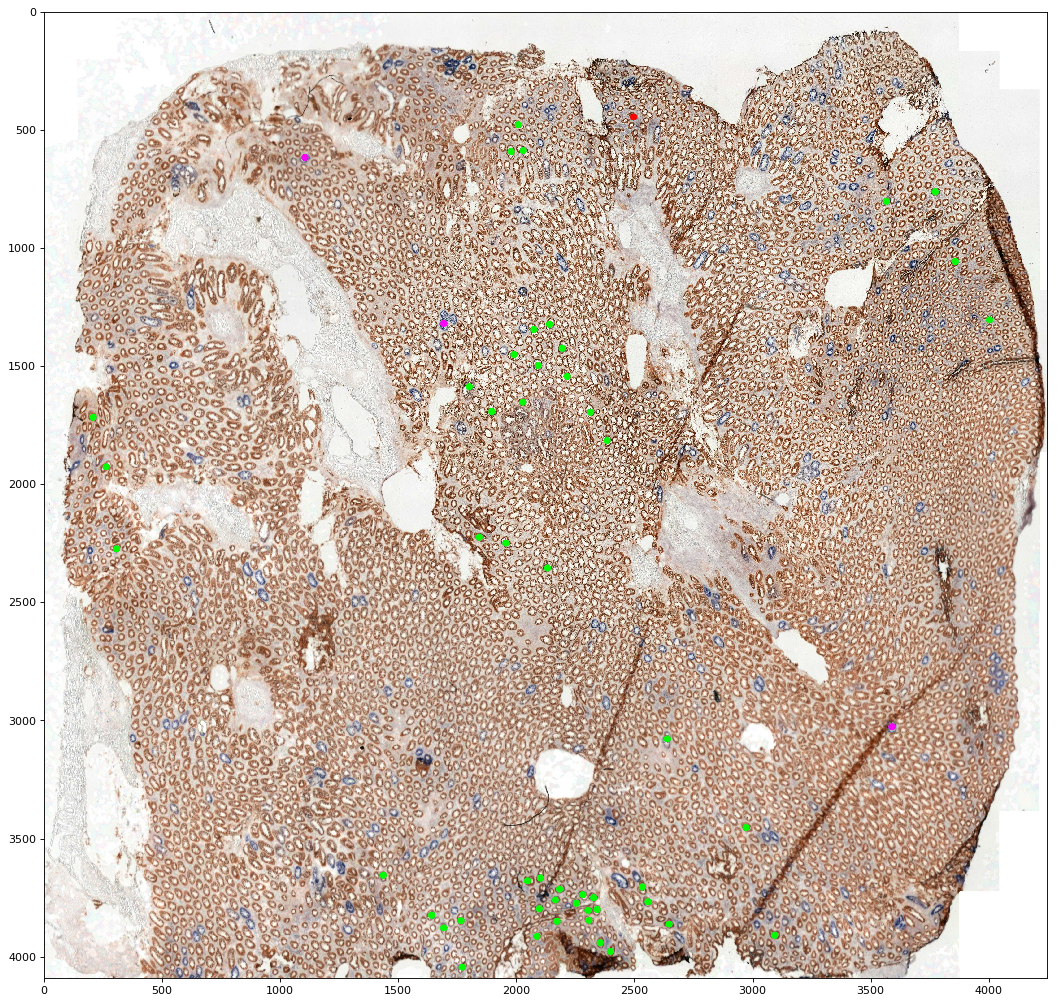

In [17]:
patient = '7A'
filename = 'data/images/{}.tif'.format(patient)


img = cv2.imread(filename)

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


In [18]:
row, col = find_points(img)
number_of_points = len(row)
mask = find_mask(img)

#we grab the indices of the mask
row_mask, col_mask = np.where(mask)
linear_indices = range(len(row_mask))

radii = np.arange(0, np.sqrt(len(row_mask) / 2), 20)

# calculate K and R for our data
K = K_function(row, col, mask, radii)
L = np.sqrt(K/np.pi)

Now we must perform a simulation of generating $n$ random points and calculating Ripley's L function for this random pattern, and then repeating this process $N_{sim}$ times. In the paper, we set $N_{sim}=999$, however each run of this simulation takes approximately 30 seconds, so for the purposes of this example we limit $N_{sim}$ to $9$. 

In [19]:
Nsim = 9

# initialize arrays to store the coordinates of the random points and 
# the K value of each run
K_simulation = np.zeros((len(radii), Nsim))
coords_simulation = np.empty((0,3), dtype=int)

for n in range(Nsim):
    # we chose n indices randomly
    random_indices = random.sample(linear_indices, number_of_points)
    # we extract the corresponding random points within the mask
    row_random, col_random = [row_mask[random_indices], col_mask[random_indices]]
    # store the random points 
    column = np.column_stack((number_of_points * [n+1], row_random, col_random))
    coords_simulation = np.concatenate([coords_simulation, column], axis=0)

    # for the random points in the sample, calculate K
    K_run = K_function(row_random, col_random, mask, radii)
    K_simulation[:, n] = K_run

# calculate L from K
L_simulation = np.sqrt(K_simulation/np.pi)

In [20]:
# scale radii and L - values by the conversion of pixels to microns
scale = 1 / 1.75 #pixels per micron
radii = radii / scale
L_simulation = L_simulation / scale
L = L / scale

L_mean = np.mean(L_simulation, 1)

Nrank = 1
significance = Nrank / (Nsim + 1)

D = np.zeros((Nsim))
for i in range(Nsim):
    Lrun = L_simulation[:, i]
    D[i] = np.max(abs(Lrun-radii))
D_sorted = np.sort(D)
D_lim = D_sorted[-Nrank]

print('The significance of this test is {}'.format(significance))

The significance of this test is 0.1


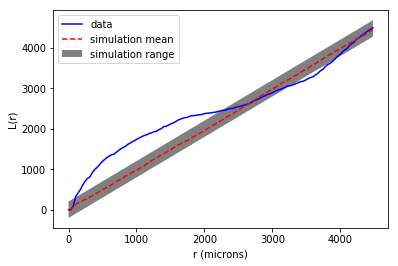

In [21]:
fig, ax = plt.subplots()
line1, = ax.plot(radii, L, 'blue')
line2, = ax.plot(radii, L_mean, 'r--')
line3 = ax.fill_between(radii, -D_lim + radii, D_lim + radii, facecolor='gray')
plt.xlabel('r (microns)')
plt.ylabel('L(r)')
plt.legend((line1, line2, line3), ('data', 'simulation mean', 'simulation range'))

This plot shows how the spatial homogeneity varies as a function of distance. Ripley's $L$ lies outside the simulation envelope between $~200$ and $2000$ microns, indicating spatial clustering at $0.1$ significance. We have attached the results of the simulation using $N_{sim}=999$, and then use these simulations to generate the plots included in the supplementary section of the manuscript at significance $0.01$.

(0.0, 1.0, 0.0, 1.0)

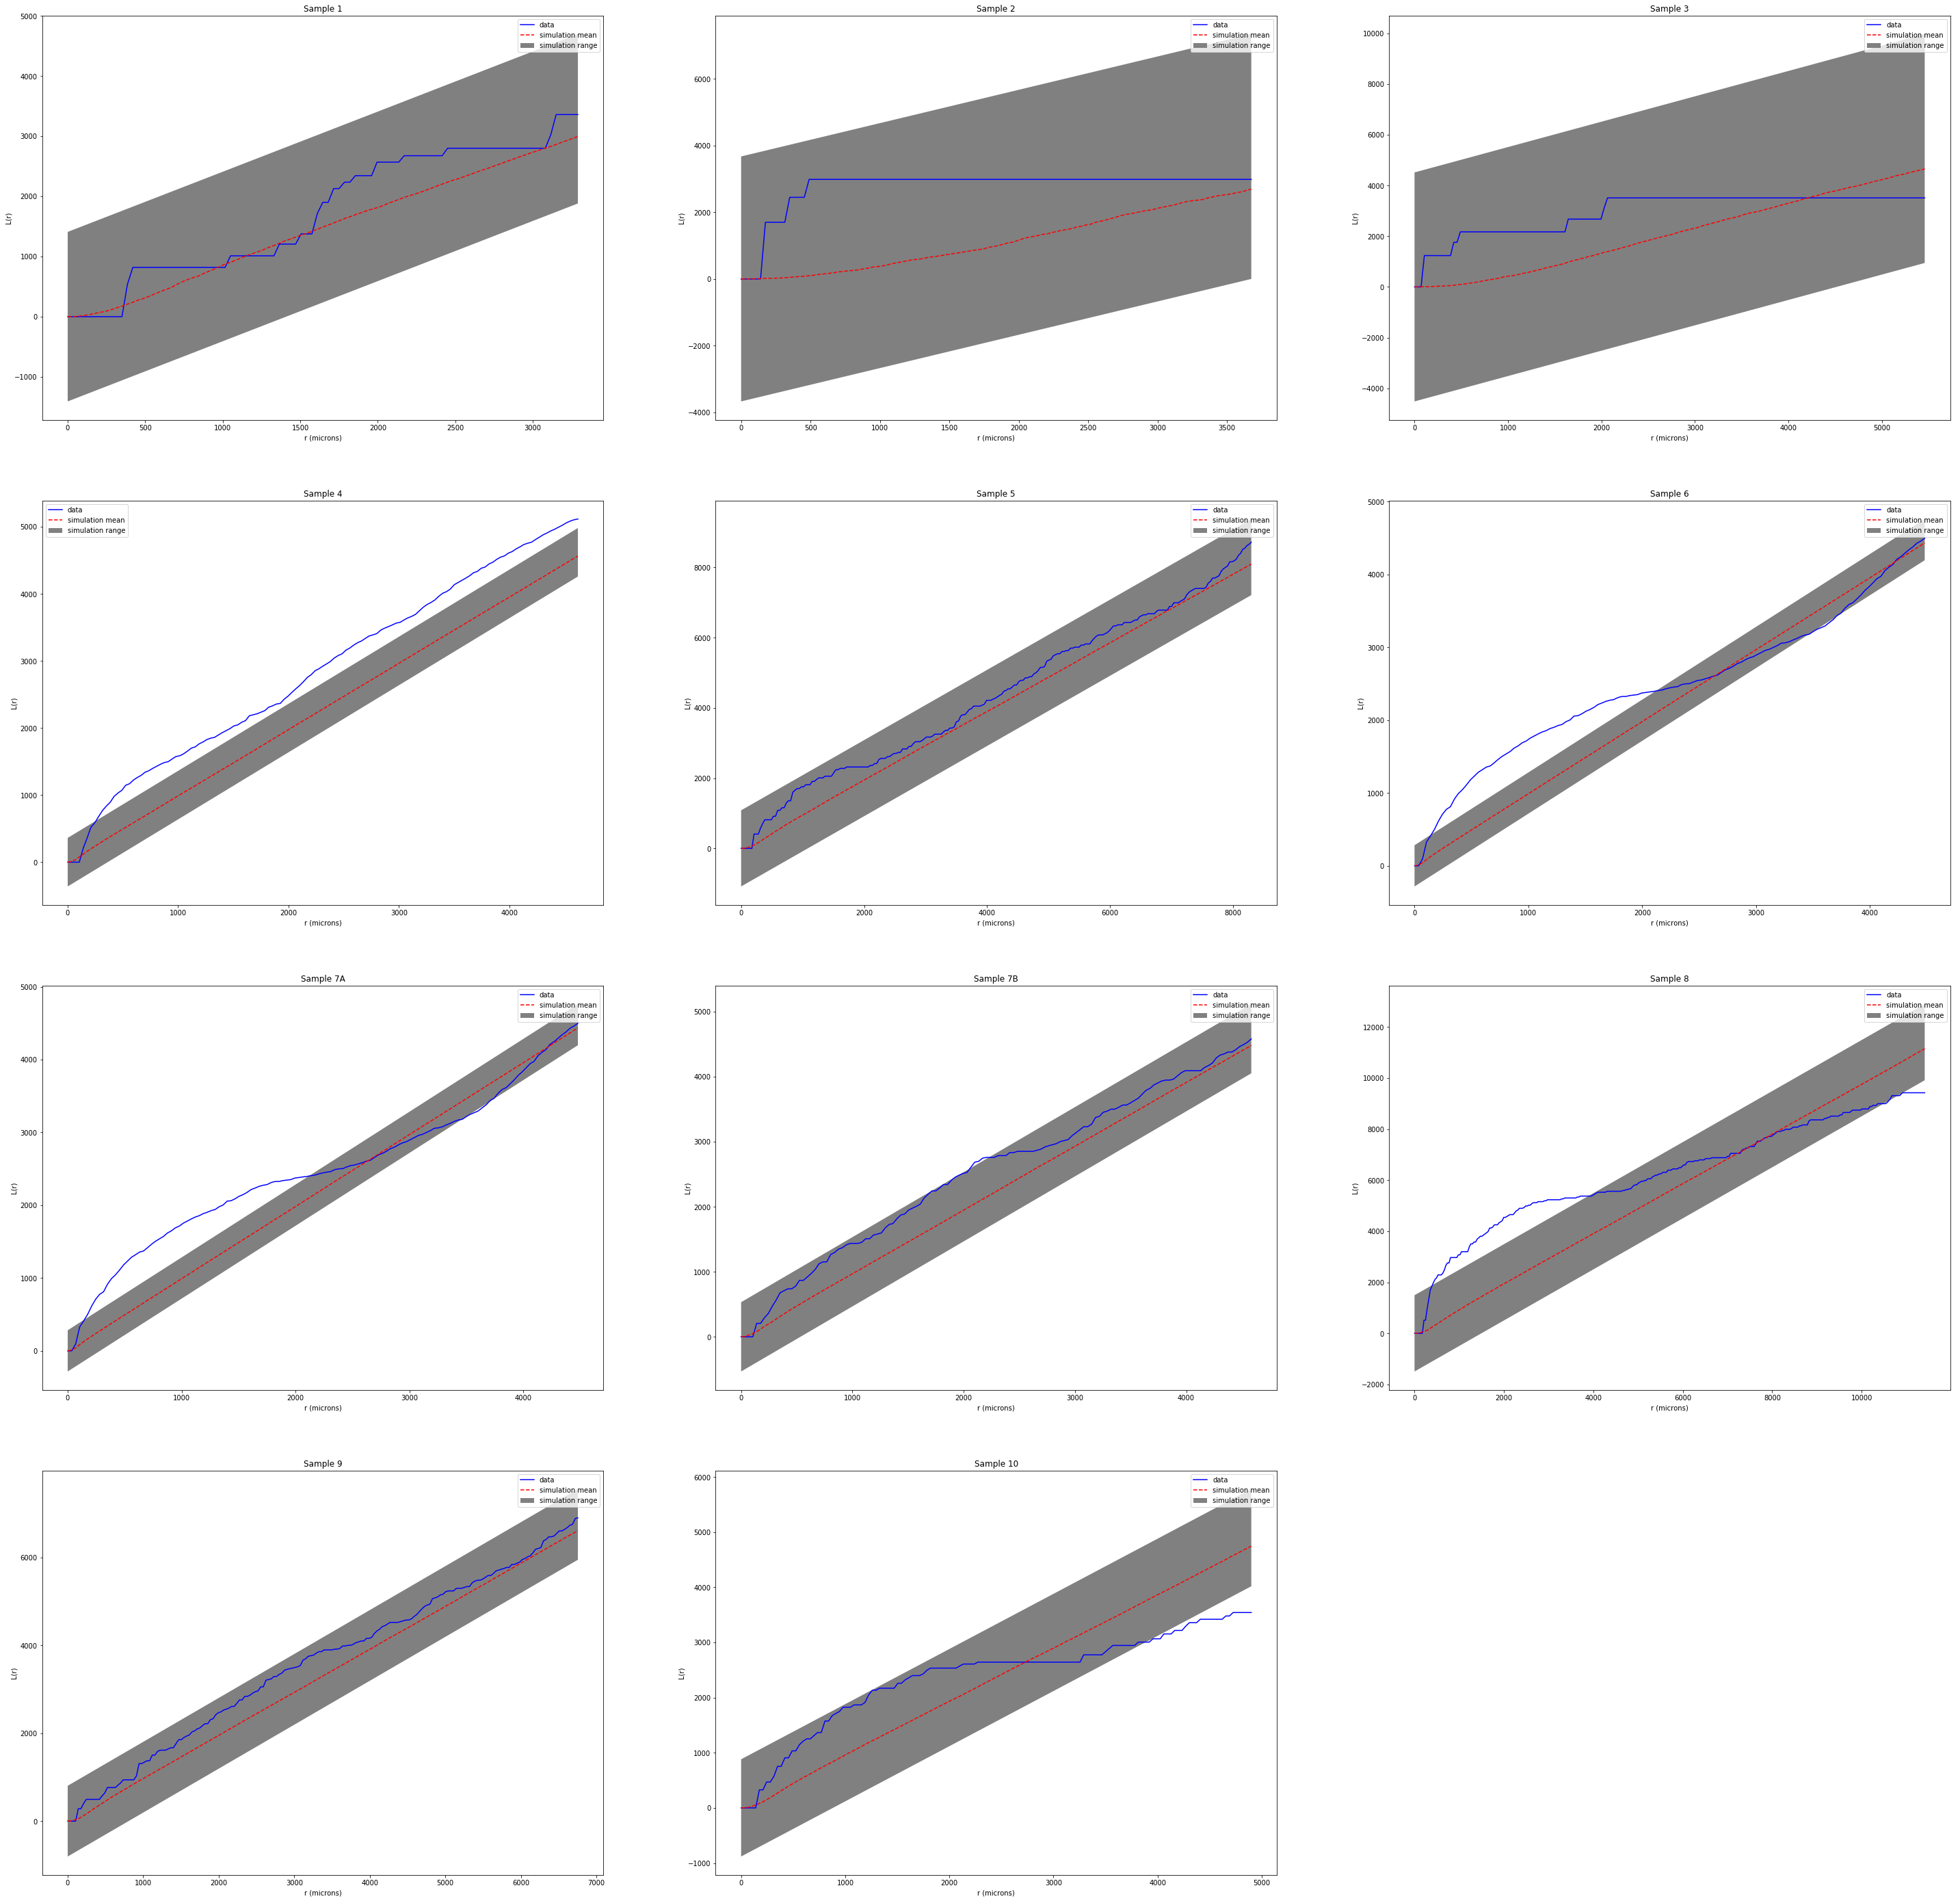

In [22]:
ripley_folder = 'data/RipleyL'
patients = ['1','2','3','4','5','6','7A','7B','8','9','10']

fig, axes = plt.subplots(4, 3, sharex='none', sharey='none', figsize=(50,50))
axes = axes.ravel()

for j, patient in enumerate(patients):
    
    patientfolder = os.path.join(ripley_folder, patient)

    with open(patientfolder + '/ripleys/Ksim.csv') as f:
        ncol = len(f.readline().split(','))
    NSIM = ncol - 1

    K_sim = np.loadtxt(patientfolder + '/ripleys/Ksim.csv', delimiter=',', usecols=range(1, ncol), skiprows=1)
    L_sim = np.loadtxt(patientfolder + '/ripleys/Lsim.csv', delimiter=',', usecols=range(1, ncol), skiprows=1)
    radii, K = np.loadtxt(patientfolder + '/ripleys/K.csv', delimiter=',' ,unpack=True, skiprows=1)
    radii, L = np.loadtxt(patientfolder + '/ripleys/L.csv', delimiter=',' ,unpack=True, skiprows=1)
    
    
    # scale radii and L - values by the conversion of pixels to microns
    scale = 1 / 1.75 #pixels per micron
    radii = radii / scale
    L_sim = L_sim / scale
    L = L / scale
    K_sim = K_sim / scale**2
    K = K / scale ** 2

    K_mean = np.mean(K_sim, 1)
    L_mean = np.mean(L_sim, 1)
    

    Nrank = 10
    significance = Nrank / (NSIM + 1)

    D = np.zeros((NSIM))
    for i in range(NSIM):
        Lrun = L_sim[:, i]
        D[i] = np.max(abs(Lrun-radii))
    D_sorted = np.sort(D)
    D_lim = D_sorted[-Nrank]

    ax = axes[j]
    line1, = ax.plot(radii, L, 'blue')
    line2, = ax.plot(radii, L_mean, 'r--')
    line3 = ax.fill_between(radii, -D_lim + radii, D_lim + radii, facecolor='gray')
    ax.set_title('Sample {}'.format(patient))
    ax.set_xlabel('r (microns)')
    ax.set_ylabel('L(r)')
    ax.legend((line1, line2, line3), ('data', 'simulation mean', 'simulation range'))


axes[-1].axis('off')


When the calculated Ripley's function for a given spatial distribution lies outside the simulation envelope the null hypothesis of spatial randomness can be rejected at significance $\alpha = \frac{N_{rank}}{1+N_{sim}}$. As can be seen, samples 4, 6, 7A, 7B, 8 and 10 all exhibit statistically significant spatial clustering. 